# Summary:
# Here in this notebook, I will build a confusion matrix for a treshold that I use to determine whether the loan is granted or not. Then next, I will look for the best threshold that will optimize the profit of our company with an algorithm.

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Importing the model from Ml Flow

import mlflow

MLFLOW_URI = 'http://127.0.0.1:7500'
        
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = MLFLOW_URI)
logged_model = 'runs:/4af57f379fb148da9a95085ec4621d9b/credit_default_model-2'

# Load model as a PyFuncModel.
loaded_model = mlflow.lightgbm.load_model(logged_model)



C:\Users\flore\projectA\streamlitenv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# Getting the data
train_df = pd.read_csv('C:\\Users\\flore\\Desktop\\opensclass\\Projet 7\\train_df_less_features.csv')

In [5]:
train_df.head()

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PAYMENT_RATE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_ANNUITY,ANNUITY_INCOME_PERC,INSTAL_DBD_MEAN,REGION_POPULATION_RELATIVE,TARGET,prediction
0,100002,0.083037,0.262949,0.139376,0.060749,-9461,-637.0,0.067329,-3648.0,-2120,24700.5,0.121978,20.421053,0.018801,1.0,0.236506
1,100003,0.311267,0.622246,NaN,0.027598,-16765,-1188.0,0.070862,-1186.0,-291,35698.5,0.132217,7.160000,0.003541,0.0,0.072170
2,100004,NaN,0.555912,0.729567,0.050000,-19046,-225.0,0.011814,-4260.0,-2531,6750.0,0.100000,7.666667,0.010032,0.0,0.038389
3,100006,NaN,0.650442,NaN,0.094941,-19005,-3039.0,0.159905,-9833.0,-2437,29686.5,0.219900,19.375000,0.008019,0.0,0.056073
4,100007,NaN,0.322738,NaN,0.042623,-19932,-3038.0,0.152418,-4311.0,-3458,21865.5,0.179963,4.590909,0.028663,0.0,0.050111


In [6]:
# Here we create a column of target values (0 or 1) for each threshold and that will help us create confusion matrixes after
# and find the optimal threshold.

# Define a custom function for this threshold
def update_column_Answer0005(row):
    if row['prediction'] <= 0.005:
        return 0
    else:
        return 1

# Apply the custom function to the new column
train_df['Answer_0.005'] = train_df.apply(update_column_Answer0005, axis=1)



def update_column_Answer00075(row):
    if row['prediction'] <= 0.0075:
        return 0
    else:
        return 1
train_df['Answer_0.0075'] = train_df.apply(update_column_Answer00075, axis=1)


def update_column_Answer001(row):
    if row['prediction'] <= 0.01:
        return 0
    else:
        return 1
train_df['Answer_0.01'] = train_df.apply(update_column_Answer001, axis=1)


def update_column_Answer002(row):
    if row['prediction'] <= 0.02:
        return 0
    else:
        return 1
train_df['Answer_0.02'] = train_df.apply(update_column_Answer002, axis=1)


def update_column_Answer003(row):
    if row['prediction'] <= 0.03:
        return 0
    else:
        return 1
train_df['Answer_0.03'] = train_df.apply(update_column_Answer003, axis=1)


def update_column_Answer004(row):
    if row['prediction'] <= 0.04:
        return 0
    else:
        return 1
train_df['Answer_0.04'] = train_df.apply(update_column_Answer004, axis=1)



def update_column_Answer005(row):
    if row['prediction'] <= 0.05:
        return 0
    else:
        return 1
train_df['Answer_0.05'] = train_df.apply(update_column_Answer005, axis=1)


def update_column_Answer0075(row):
    if row['prediction'] <= 0.075:
        return 0
    else:
        return 1
train_df['Answer_0.075'] = train_df.apply(update_column_Answer0075, axis=1)


def update_column_Answer01(row):
    if row['prediction'] <= 0.1:
        return 0
    else:
        return 1
train_df['Answer_0.1'] = train_df.apply(update_column_Answer01, axis=1)


def update_column_Answer0125(row):
    if row['prediction'] <= 0.125:
        return 0
    else:
        return 1
train_df['Answer_0.125'] = train_df.apply(update_column_Answer0125, axis=1)


def update_column_Answer015(row):
    if row['prediction'] <= 0.15:
        return 0
    else:
        return 1
train_df['Answer_0.15'] = train_df.apply(update_column_Answer015, axis=1)


def update_column_Answer02(row):
    if row['prediction'] <= 0.2:
        return 0
    else:
        return 1
train_df['Answer_0.2'] = train_df.apply(update_column_Answer02, axis=1)


def update_column_Answer03(row):
    if row['prediction'] <= 0.3:
        return 0
    else:
        return 1
train_df['Answer_0.3'] = train_df.apply(update_column_Answer03, axis=1)


def update_column_Answer04(row):
    if row['prediction'] <= 0.4:
        return 0
    else:
        return 1
train_df['Answer_0.4'] = train_df.apply(update_column_Answer04, axis=1)


def update_column_Answer05(row):
    if row['prediction'] <= 0.5:
        return 0
    else:
        return 1
train_df['Answer_0.5'] = train_df.apply(update_column_Answer05, axis=1)

w
def update_column_Answer06(row):
    if row['prediction'] <= 0.6:
        return 0
    else:
        return 1
train_df['Answer_0.6'] = train_df.apply(update_column_Answer06, axis=1)


def update_column_Answer07(row):
    if row['prediction'] <= 0.7:
        return 0
    else:
        return 1
train_df['Answer_0.7'] = train_df.apply(update_column_Answer07, axis=1)

In [7]:
train_df.head()

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PAYMENT_RATE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,Answer_0.075,Answer_0.1,Answer_0.125,Answer_0.15,Answer_0.2,Answer_0.3,Answer_0.4,Answer_0.5,Answer_0.6,Answer_0.7
0,100002,0.083037,0.262949,0.139376,0.060749,-9461,-637.0,0.067329,-3648.0,-2120,...,1,1,1,1,1,0,0,0,0,0
1,100003,0.311267,0.622246,NaN,0.027598,-16765,-1188.0,0.070862,-1186.0,-291,...,0,0,0,0,0,0,0,0,0,0
2,100004,NaN,0.555912,0.729567,0.050000,-19046,-225.0,0.011814,-4260.0,-2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,NaN,0.650442,NaN,0.094941,-19005,-3039.0,0.159905,-9833.0,-2437,...,0,0,0,0,0,0,0,0,0,0
4,100007,NaN,0.322738,NaN,0.042623,-19932,-3038.0,0.152418,-4311.0,-3458,...,0,0,0,0,0,0,0,0,0,0


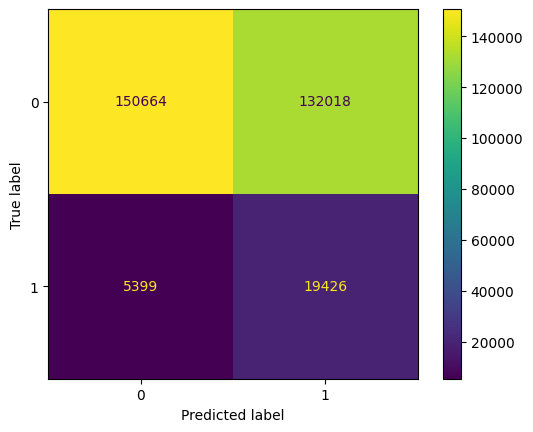

In [8]:
# Here we made a confusion matrix for a threshold

from sklearn import metrics
    
confusion_matrix = metrics.confusion_matrix(train_df['TARGET'], train_df['Answer_0.04'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

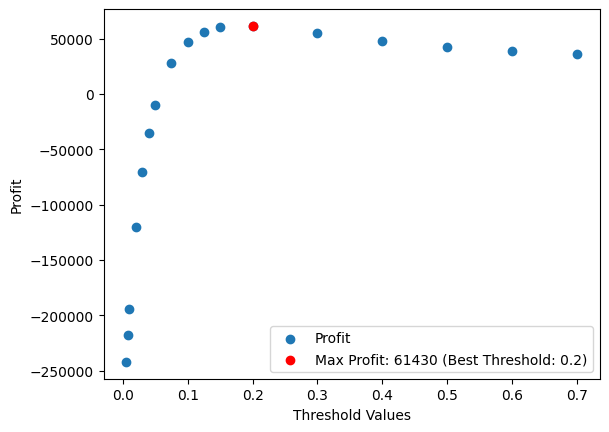

In [11]:
# Here we are making an algorithm to find the best threshold that would make the most profit for our company

# Thresholds
liste1 = [0.005, 0.0075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
profit = []

# Calculating the total profit for each threshold by adding the profits from the loans granted (10 % profit), substracting 
# the profits we didn't make (10 % profit again) and substracting the loss on the loans that defaulted (100%).
for i in liste1:
    confusion_matrix = metrics.confusion_matrix(train_df['TARGET'], train_df['Answer_' + str(i)])
    profit.append(confusion_matrix[0][0] - confusion_matrix[0][1] - (10 * (confusion_matrix[1][0])))
    
# Find the index of the maximum profit value
max_profit_index = profit.index(max(profit))

# Create a scatter plot
plt.scatter(liste1, profit, label='Profit')

# Highlight the maximum profit point in red
plt.scatter(liste1[max_profit_index], profit[max_profit_index], c='red', label=f'Max Profit: {profit[max_profit_index]}', marker='o')

# Add labels and legend
plt.xlabel('Threshold Values')
plt.ylabel('Profit')
plt.legend(loc='upper right')  # Set legend position to upper right

# Add the best threshold to the legend
plt.legend(['Profit', f'Max Profit: {profit[max_profit_index]} (Best Threshold: {liste1[max_profit_index]})'])

# Show the plot
plt.show()